In [1]:
from tensorflow import keras
from keras import regularizers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from dataset_generator import LineDatasetGenerator
from loaded_model import LoadedModel
from random import randint
from constants import *

Initialize dataset generator:

In [2]:
data_gen = LineDatasetGenerator(IMAGE_SIZE)

Create datasets:

In [3]:
train_images, train_results = data_gen.create_set(set_size=int(TRAIN_SPLIT*SIZE_OF_DATASET))
valid_images, valid_results = data_gen.create_set(set_size=int(VALID_SPLIT*SIZE_OF_DATASET))
test_images, test_results = data_gen.create_set(set_size=int(TEST_SPLIT*SIZE_OF_DATASET))

In [4]:
print(train_images.shape, train_results.shape)
print(valid_images.shape, valid_results.shape)
print(test_images.shape, test_results.shape)

(14000, 64, 64) (14000, 4)
(3000, 64, 64) (3000, 4)
(3000, 64, 64) (3000, 4)


Draw image of choice:

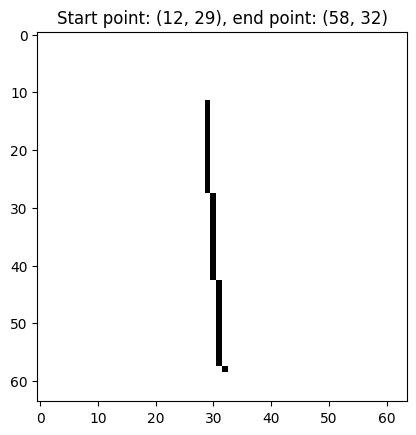

In [5]:
data_gen.draw_image(train_images[4], train_results[4])

Draw random images:

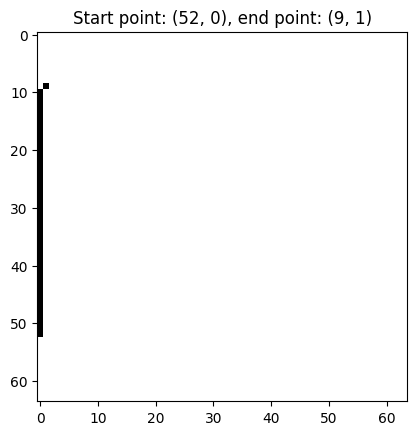

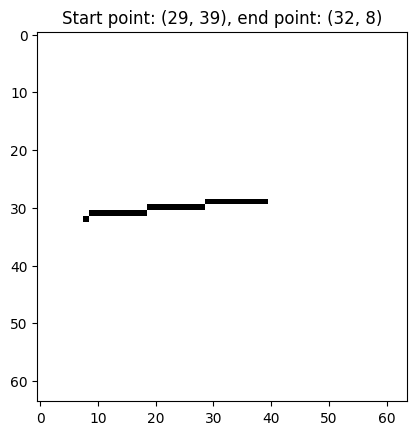

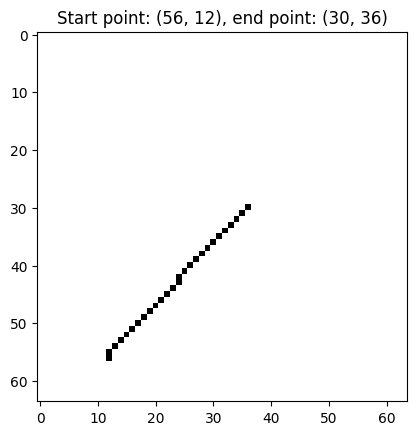

In [6]:
for _ in range(3):
  data_gen.draw_random_image()

Define network architecture. Droput layers and kernel regularizer added to fight with overfitting. Results still not satisfying.

In [7]:
model = keras.Sequential([
    # convolutional layers
    keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(64,64,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # flattening
    keras.layers.Flatten(),
    
    # fully connected layers
    keras.layers.Dense(512, activation='relu'),
    # keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    # keras.layers.Dense(256, activation='relu', regularizers=regularizers.l2(0.001))),
    # keras.layers.Dropout(0.25),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(4)
])

In [8]:
model.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(learning_rate=1e-03),
    metrics=tfa.metrics.r_square.RSquare()
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

Define early stopping criteria (it was not eventually used due to the problem with constant validation loss increase):

In [10]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', 
                          mode="min",
                          patience=20,
                          verbose=1)

Train model with training data with *batch_size* and *epochs* set in **constants.py**. Net is evaluated during training with validation data to determine if model is overfitting:

In [11]:
history = model.fit(
    train_images, # Input training data
    train_results, # Output training data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1, # Details to be printed during training
    validation_data = (valid_images, valid_results),
    # callbacks = [es],
)

Epoch 1/100
219/219 [==============================] - 25s 108ms/step - loss: 367.0079 - r_square: -0.0699 - val_loss: 242.0792 - val_r_square: 0.2851
Epoch 2/100
219/219 [==============================] - 23s 104ms/step - loss: 216.9458 - r_square: 0.3675 - val_loss: 196.0505 - val_r_square: 0.4210
Epoch 3/100
219/219 [==============================] - 27s 125ms/step - loss: 193.7403 - r_square: 0.4352 - val_loss: 189.0468 - val_r_square: 0.4417
Epoch 4/100
219/219 [==============================] - 25s 115ms/step - loss: 188.5163 - r_square: 0.4504 - val_loss: 183.7148 - val_r_square: 0.4574
Epoch 5/100
219/219 [==============================] - 22s 99ms/step - loss: 185.7446 - r_square: 0.4585 - val_loss: 182.9725 - val_r_square: 0.4596
Epoch 6/100
219/219 [==============================] - 21s 96ms/step - loss: 185.1165 - r_square: 0.4603 - val_loss: 182.6916 - val_r_square: 0.4605
Epoch 7/100
219/219 [==============================] - 20s 89ms/step - loss: 183.7522 - r_square: 0.4

Plot training history:

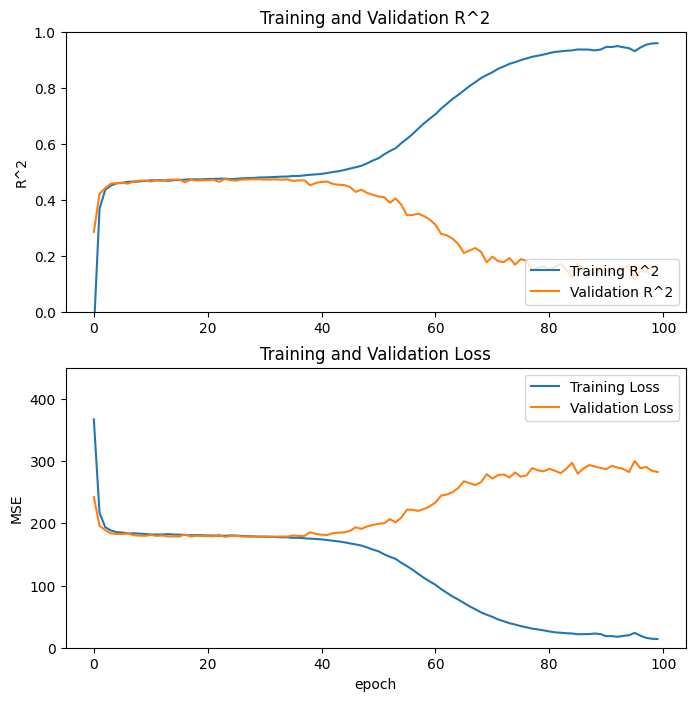

In [12]:
acc = history.history['r_square']
val_acc = history.history['val_r_square']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training R^2')
plt.plot(val_acc, label='Validation R^2')
plt.legend(loc='lower right')
plt.ylabel('R^2')
plt.ylim([0,1])
plt.title('Training and Validation R^2')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0, max(val_loss)*1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Evaluate model with test data:

In [13]:
score = model.evaluate(test_images, test_results, verbose=1)

94/94 [==============================] - 1s 11ms/step - loss: 298.2247 - r_square: 0.1353


Save model:

In [14]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ../models/line_detector_v5/assets


INFO:tensorflow:Assets written to: ../models/line_detector_v5/assets


Load model to use new implemented methods:

In [15]:
loaded_model = LoadedModel(MODEL_PATH, train_images, train_results)

438/438 [==============================] - 5s 10ms/step


Rounded accuracy, calculated by checking for every row of results if absolute difference between them and corresponding predictions row is lower than given threshold:

In [23]:
rounded_acc = loaded_model.rounded_acc(2.5)
rounded_acc

0.3836428571428571

Draw random images with predictions (red points):

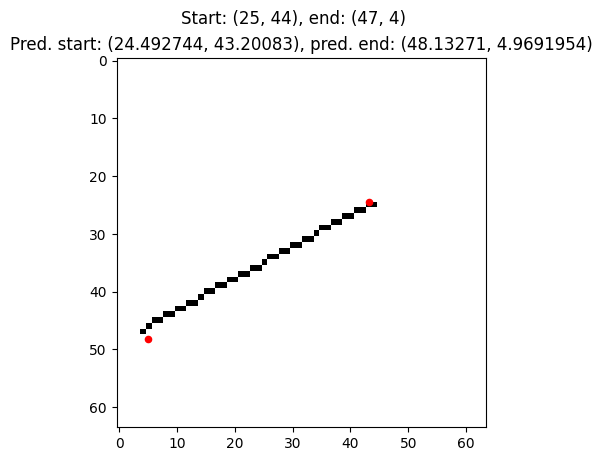

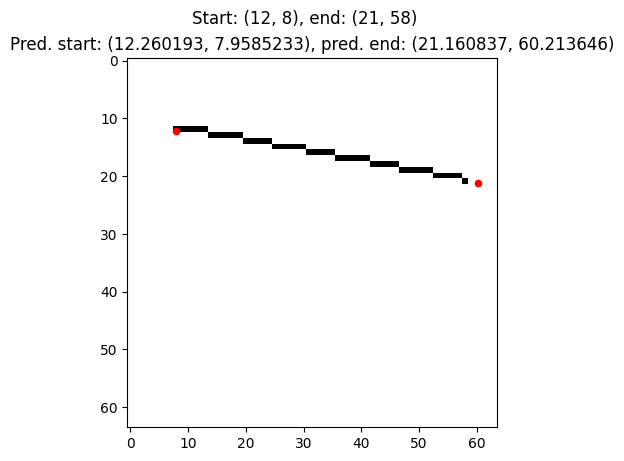

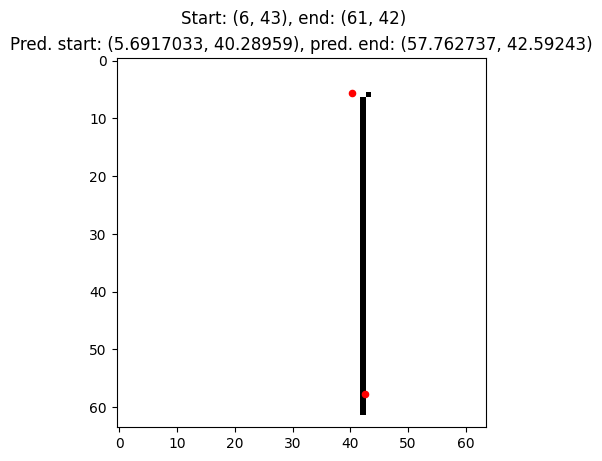

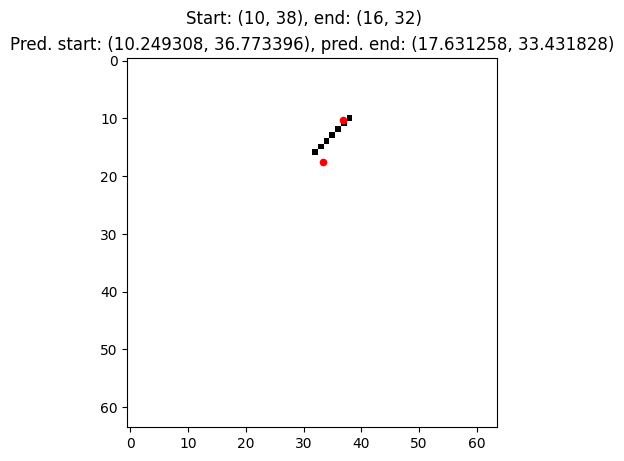

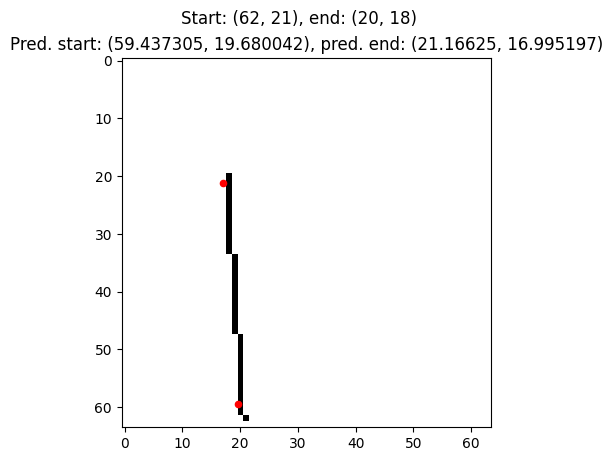

In [18]:
for _ in range(5):
  loaded_model.draw_prediction(randint(0, len(loaded_model.test_images)))